In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from helpers import all_models_test, plot_predicted_vs_actual
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings


warnings.filterwarnings('ignore')


In [17]:
storage_dir = "Dataset/mydata/chol_tcga_pan_can_atlas_2018/"
mutations_df = pd.read_csv(storage_dir+"mutations_summary.csv")

pathological_df = pd.read_csv(storage_dir+"pathological_df.csv")

# df = pd.merge(pathological_df, mutations_df, left_on='SAMPLE_ID', right_on="Tumor_Sample_Barcode", how='inner')
# df.head()

In [18]:
mutations_pcs = np.load(storage_dir+"mutations_pcs.npy")
mutations_emb_df = pd.DataFrame(mutations_pcs, columns=[f"MPC{i}" for i in range(1, 37)])
print(mutations_df.shape, mutations_emb_df.shape)

(36, 3) (36, 36)


In [19]:
mutations_emb_df["SAMPLE_ID"] = mutations_df["Tumor_Sample_Barcode"]

# pd.merge(pathological_df, mutations_emb_df, left_on="SAMPLE_ID")

In [20]:
df = pd.merge(pathological_df, mutations_emb_df, on="SAMPLE_ID", how="inner")

df = df.drop(['CANCER_TYPE', 'PATIENT_ID', 'SAMPLE_ID'], axis=1)
df.head()

,WEIGHT,PFS_MONTHS,GRADE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,CANCER_STAGE,AGE_AT_INITIAL_DIAGNOSIS,M_STAGE,...,MPC27,MPC28,MPC29,MPC30,MPC31,MPC32,MPC33,MPC34,MPC35,MPC36
0,52,7.101292,2,10,0.3138,0.00,1.433333,1.0,72.139630,0.0,...,0.297500,1.091584,-1.775238,2.672930,2.247378,3.042557,0.196324,-1.986215,-0.203015,-1.853332e-06
1,92,8.679357,2,5,0.3468,0.02,1.000000,2.0,50.110883,0.0,...,3.363971,-2.034311,1.149315,1.014117,-0.597349,1.207162,-0.477922,0.423363,0.049962,2.001878e-06
2,67,13.939573,2,9,0.3473,0.07,1.333333,2.0,71.154004,0.0,...,3.003227,0.099267,2.573835,0.355901,-0.772669,0.274115,0.491398,1.164235,-0.099169,4.945250e-07
3,125,7.134168,2,6,0.3394,0.14,3.166667,1.0,66.770705,0.0,...,-2.879627,-0.604600,-1.293652,1.743863,-2.828918,-1.388689,-0.521755,-2.267310,-0.124209,-5.122274e-08
4,73,7.068416,3,12,0.3436,0.18,1.633333,1.0,57.817933,0.0,...,1.066492,-0.365881,-0.147126,-0.398827,0.212347,1.021367,1.549329,0.117687,-0.030962,1.776963e-06


In [21]:
df1 = df[['WEIGHT', 'GRADE', 'ANEUPLOIDY_SCORE', 'MSI_SCORE_MANTIS',
       'MSI_SENSOR_SCORE', 'TMB_NONSYNONYMOUS', 'CANCER_STAGE',
       'AGE_AT_INITIAL_DIAGNOSIS', 'M_STAGE', 'N_STAGE', 'T_STAGE', 'SEX_Male',
       'PERSON_NEOPLASM_CANCER_STATUS_With Tumor', 'PRIOR_DX_Yes',
       'RACE_Black or African American', 'RACE_White', 'ONCOTREE_CODE_PHCH']]

df2 = df[['MPC1', 'MPC2', 'MPC3', 'MPC4', 'MPC5', 'MPC6', 'MPC7', 'MPC8', 'MPC9','MPC10']]

y = df['PFS_MONTHS']


In [22]:
scaler = StandardScaler()
scaler.fit(df1)

StandardScaler()

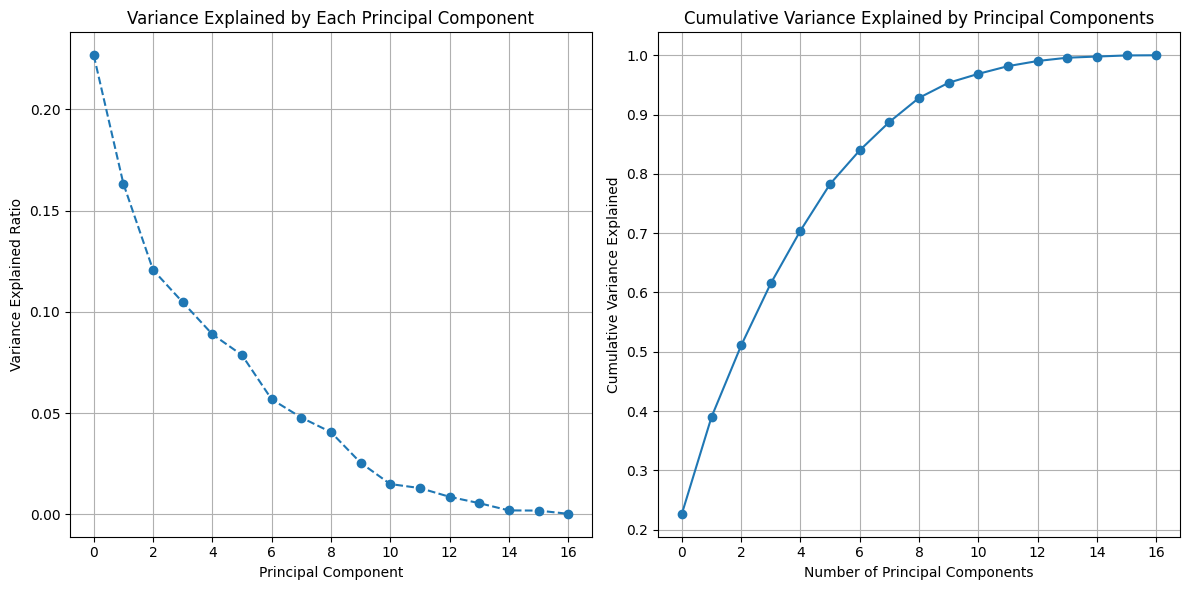

In [23]:
df1_std = scaler.transform(df1)

pca = PCA()

pca.fit(df1_std)

# Plot variance explained by each principal component
plt.figure(figsize=(12, 6))

# Plot explained variance ratio of each principal component
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)

# Plot cumulative variance explained
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)

plt.tight_layout()
plt.show()

Elbows at 2, 4, 6 PCs

In [24]:
X1 = pca.transform(df1_std)

n_components = 2
first_2_pcs = X1[:, :n_components]
print("Shape of first 2 principal components:", first_2_pcs.shape)

n_components = 4
first_4_pcs = X1[:, :n_components]
print("Shape of first 4 principal components:", first_4_pcs.shape)

n_components = 6
first_6_pcs = X1[:, :n_components]
print("Shape of first 4 principal components:", first_6_pcs.shape)

Shape of first 2 principal components: (20, 2)
Shape of first 4 principal components: (20, 4)
Shape of first 4 principal components: (20, 6)


## Combine pathological PCs with mutation PCs

In [25]:
m_10_pcs = df2.to_numpy()
m_10_pcs.shape

(20, 10)

In [26]:
X = np.concatenate((m_10_pcs, first_2_pcs), axis=1)
X.shape

(20, 12)

In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Regressor": SVR()
}

predictions = all_models_test(models, X, y)


Linear Regression - RMSE: 8.0369, R2: -217.8405%
Ridge Regression - RMSE: 7.6899, R2: -190.9872%
Lasso Regression - RMSE: 4.9444, R2: -20.2959%
Decision Tree Regression - RMSE: 6.0296, R2: -78.8978%
Random Forest Regression - RMSE: 4.8804, R2: -17.2055%
Gradient Boosting Regression - RMSE: 5.2451, R2: -35.3764%
Support Vector Regressor - RMSE: 4.6431, R2: -6.0833%


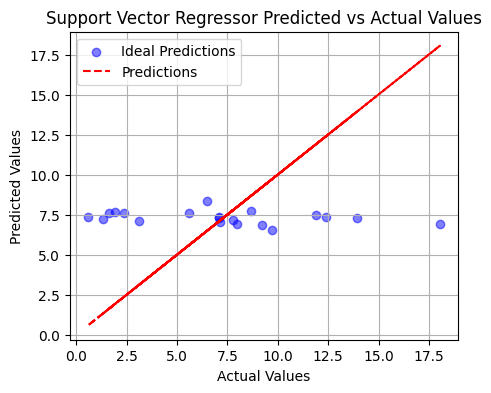

In [28]:
plot_predicted_vs_actual(predictions, "Support Vector Regressor")

Linear Regression - RMSE: 10.5931, R2: -452.1788%
Ridge Regression - RMSE: 9.7020, R2: -363.1836%
Lasso Regression - RMSE: 5.2895, R2: -37.6781%
Decision Tree Regression - RMSE: 6.9476, R2: -137.5216%
Random Forest Regression - RMSE: 4.7504, R2: -11.0424%
Gradient Boosting Regression - RMSE: 5.8414, R2: -67.9052%
Support Vector Regressor - RMSE: 4.6392, R2: -5.9066%


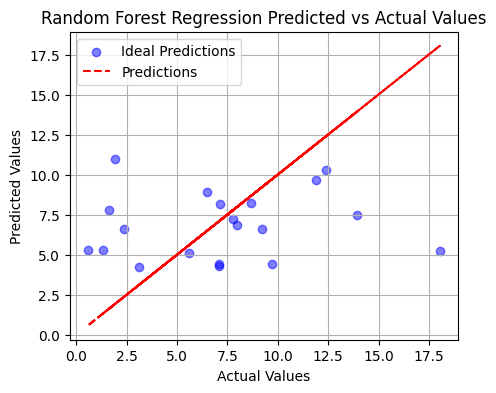

In [34]:
# trying 4 pcs
X = np.concatenate((m_10_pcs, first_4_pcs), axis=1)

predictions = all_models_test(models, X, y)

plot_predicted_vs_actual(predictions, "Random Forest Regression")

(-1.0, 14.0)

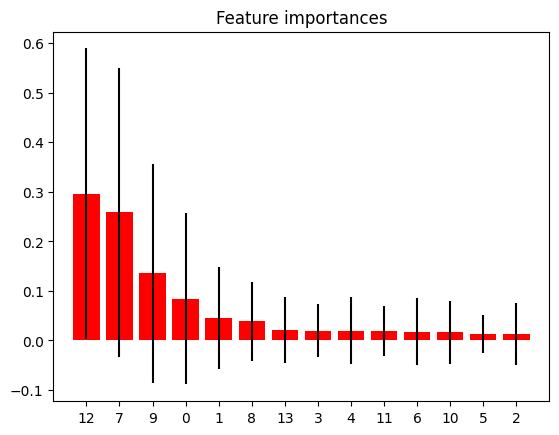

In [35]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to the data
rf_regressor.fit(X, y)

# Get feature importances
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
